In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy.random import rand, normal
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Constants

In [3]:
f12 = 0.4162                  # Oscillator strength
c   = 2.99792458e10           # Speed of light (cm/sec)
ν0  = 2.466e15                # Lya frequency (Hz)
λ0  = c / ν0                  # Lya wavelength (cm)
ΔνL = 9.936e7                 # Natural line width (Hz)
me  = 9.109382917e-28         # Electron mass (g)
ee  = 4.80320451e-10          # Electron charge in g^(1/2) cm^(3/2) / s
kB  = 1.380648813e-16         # Boltzmann's constant (g cm^2/sec^2/k)
mH  = 1.6735327e-24           # Mass of hydrogen atom (g)
h   = 6.626069573e-27         # Planck's constant (erg s)

km  = 1e5                     # Units: 1 km = 1e5  cm
pc  = 3.085677581467192e18    # Units: 1 pc = 3e18 cm

# Thermal velocity: vth_div_sqrtT = vth / sqrt(T)
vth_div_sqrtT = np.sqrt(2. * kB / mH)
# Doppler width: ΔνD_div_sqrtT = ΔνD / sqrt(T)  (ΔνD = ν0*vth/c)
ΔνD_div_sqrtT = ν0 * vth_div_sqrtT / c
# "damping parameter": a_sqrtT = a * sqrt(T)
a_sqrtT = c * ΔνL * mH / (2. * ν0 * np.sqrt(2. * kB * mH))
# Cross section: σ0_sqrtT = σ0 * sqrt(T)
σ0_sqrtT = np.sqrt(np.pi/2) * f12 * ee * ee * np.sqrt(mH/kB) / (me * ν0)

# Initial Conditions

In [4]:
aτ0  = 2e3  # Optically thick if a * tau0 > 1000
T    = 1e4  # Temperature (K)
zmax = 1.   # Center-to-edge distance in plane parallel geometry

## Derived parameters ##
vth  = vth_div_sqrtT * np.sqrt(T)     # Thermal velocity (cm/s)
ΔνD  = ΔνD_div_sqrtT * np.sqrt(T)     # Doppler width (Hz)
a    = a_sqrtT / np.sqrt(T)           # "damping parameter"
τ0   = aτ0 / a                        # Optical depth at line center
σ0   = σ0_sqrtT / np.sqrt(T)          # Cross-section at line center (cm^2)
k0   = τ0 / zmax                      # Absorption coefficient (cm^-1)
N0   = τ0 / σ0                        # Column density (cm^-2)
n0   = N0 / zmax                      # Number density (cm^-3)
dz0  = np.sqrt(np.pi) / (a * k0)      # Convenience: sqrt(pi) / (a kH)
# Core-wing transition frequency: exp(-x_cw^2) ~ a / (sqrt(pi) x_cw^2)
x_cw = fsolve(lambda y : np.exp(-y*y) - a / (np.sqrt(np.pi) * y*y), 0.5)[0]
x_cs = max(x_cw+1., .2*aτ0**(1./3.))  # Core-skipping value Note: coefficient should be small ~ 0.2 * atau0^(1/3)
x_cs2 = x_cs**2                       # Convenience: x_cs^2

## Print Lyman-alpha properties ##
print('Lyman-alpha properties:'
      f'\n  aτ0  = {aτ0}'
      f'\n  T    = {T} K'
      f'\n  zmax = {zmax} cm\n'
      f'\n  x_cw = {x_cw}'
      f'\n  x_cs = {x_cs}'
      f'\n  vth  = {vth/km} km/s'
      f'\n  ΔνD  = {ΔνD/1e9} GHz'
      f'\n  a    = {a}'
      f'\n  τ0   = {τ0}'
      f'\n  σ0   = {σ0} cm^2'
      f'\n  k0   = {k0} cm^-1'
      f'\n  N0   = {N0} cm^-2'
      f'\n  n0   = {n0} cm^-3'
      f'\n  dz0  = {dz0}')

Lyman-alpha properties:
  aτ0  = 2000.0
  T    = 10000.0 K
  zmax = 1.0 cm

  x_cw = 3.255018090644676
  x_cs = 4.2550180906446755
  vth  = 12.845159709869076 km/s
  ΔνD  = 105.66030932151449 GHz
  a    = 0.00047018601704854355
  τ0   = 4253635.640962741
  σ0   = 5.898174674107242e-14 cm^2
  k0   = 4253635.640962741 cm^-1
  N0   = 7.211783095600808e+19 cm^-2
  n0   = 7.211783095600808e+19 cm^-3
  dz0  = 0.000886226925452758


# Helper functions

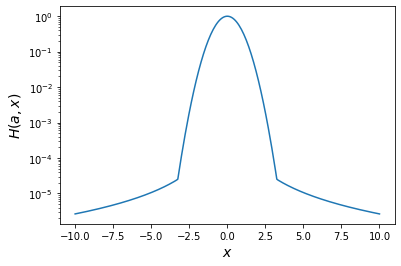

In [5]:
## Voigt function ##
sqrt_pi = np.sqrt(np.pi)
def H(x):
    if np.abs(x) < x_cw: # Core photon  =>  H(a,x) ~ ecp(-x^2)
        return np.exp(-x*x)
    else:        # Wing photon  =>  H(a,x) ~ a / (sqrt(pi) x^2)
        return a / (sqrt_pi * x*x)

x = np.linspace(-10, 10, 250)
plt.semilogy(x, [H(x_i) for x_i in x])
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$H(a,x)$', fontsize=14)
plt.show()

# Lyman-alpha Radiative Transfer

* Psuedo-code

    Initialize photon position and frequency
    
    Loop until photon escapes (z > z_max = 1):
        Scatter:
            if in core: core-skip  =>  x' = +/- x_cs
            if in wing: x' = Gaussian(mean=x-1/x, stdev=1)
        Move:
            draw optical depth: dtau = -log(R)
            draw direction: μ = 2R - 1
            new position is z' = z + μ dτ / (k_H * H(a,x)) = z + μ dτ dz(x)

In [6]:
## Track a single photon to escape ##
def photon():
    z = 0.                      # Initialize each photon at the center of the slab
    x = 0.                      # Initialize each photon at line center: x = (ν - ν0) / ΔνD
    while np.abs(z) < zmax:
        ## Scatter: 'frequency redistribution'
        if np.abs(x) < x_cw:    # Core-skipping => Zero mean free path approximation
            x = x_cs
            if rand() < 0.5: x = -x # Force symmetry for core-skipping
        else:                   # Wing scattering approximated by <dx> = -1/x and <dx^2> = 1
            x += normal() - 1. / x
        ## Move: Photon z position changes by cos(θ) * dτ / [k0 * H(x)]
        μ = 2.*rand() - 1.      # Random direction: uniformly distributed in [-1,1]
        dτ = -np.log(rand())    # Random optical depth: dτ = -ln(R)
        z += μ * dτ * dz0 * x * x # i.e. Δz = μ dτ / (k0 * H(x))
    return x

In [7]:
## Run simulation ##
n_photons = 5000  # Number of Monte-Carlo photon packets
x = np.array([photon() for i in range(n_photons)])

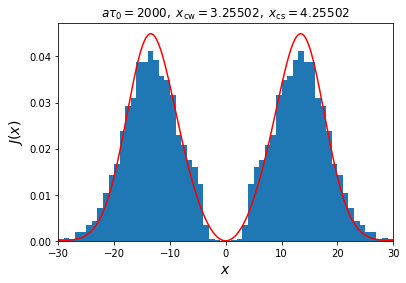

In [8]:
## Plot results ##
aτ0_1_3 = aτ0**(1./3.)
plt.hist(np.hstack([x,-x]), bins=int(np.sqrt(2.*n_photons)), range=(-50,50), density=True)
xa = np.linspace(-40, 40, 250)
Ja = np.sqrt(np.pi/6.)*xa**2/aτ0/np.cosh(np.sqrt(np.pi**3/54.)*xa**3/aτ0)
plt.plot(xa, Ja, 'r')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$J(x)$', fontsize=14)
plt.gca().set_xlim([-30.,30.]);
plt.title(r"$a\tau_0 = %g, \; x_{\rm cw} = %g, \; x_{\rm cs} = %g$" % (aτ0, x_cw, x_cs))
plt.savefig('J_MCRT.pdf', bbox_inches='tight')